# GlowBlock

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math
import os
from copy import deepcopy
from pathlib import Path

import matplotlib.pyplot as plt
import normflows as nf
import numpy as np
import pytorch_lightning as pl
import seaborn as sns
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets.utils as dataset_utils
from PIL import Image
from pl_bolts.models.autoencoders.components import resnet18_decoder, resnet18_encoder
from torchvision import datasets, transforms
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

from gendis.datasets import CausalMNIST, ClusteredMultiDistrDataModule

/Users/adam2392/miniforge3/envs/cdrl/lib/python3.10/site-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/Users/adam2392/miniforge3/envs/cdrl/lib/python3.10/site-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/Users/adam2392/miniforge3/envs/cdrl/lib/python3.10/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/Users/adam2392/miniforge3/envs/cdrl/lib/python3.

In [8]:
# Set up model

# Define flows
L = 2
K = 16
torch.manual_seed(0)

input_shape = (3, 28, 28)
n_dims = np.prod(input_shape)
channels = 3
n_chs_now = 3
hidden_channels = 256
split_mode = "channel"
# split_mode = "checkerboard"
scale = True

# Set up flows, distributions and merge operations
q0 = []
merges = []
flows = []

# add flows in from the prior to the output
for i in range(L):
    flows_ = []
    n_chs_now = channels * 2 ** (L + 1 - i)  # x 4 per time
    for j in range(K):
        flows_ += [
            nf.flows.GlowBlock(
                n_chs_now,
                hidden_channels,
                split_mode=split_mode,
                scale=scale,
            )
        ]
    flows_ += [nf.flows.Squeeze()]
    flows += [flows_]
    if i > 0:
        merges += [nf.flows.Merge()]
        latent_shape = (
            input_shape[0] * 2 ** (L - i),
            input_shape[1] // 2 ** (L - i),
            input_shape[2] // 2 ** (L - i),
        )
    else:
        latent_shape = (
            input_shape[0] * 2 ** (L + 1),
            input_shape[1] // 2**L,
            input_shape[2] // 2**L,
        )
    q0 += [nf.distributions.DiagGaussian(latent_shape)]
    print(f"\n\n At Layer {L - i}")
    print(n_chs_now)
    print(latent_shape)

# Construct flow model with the multiscale architecture
model = nf.MultiscaleFlow(q0, flows, merges)



 At Layer 2
24
(24, 7, 7)


 At Layer 1
12
(6, 14, 14)


In [9]:
batch_size = 5

output, ldj = torch.randn(batch_size, 3, 28, 28), 0
# output
output = output - output.min()
output = output / output.max() * 255
# output, ldj = model.forward_and_log_det(output)
output, ldj = model.inverse_and_log_det(output)

print([x.shape for x in output])
print(ldj.shape)
# for idx, flow in enumerate(model.flows):
#     # try:
#     #     print(flow.batch_dims, flow.n_dim, flow.s.shape)
#     # except Exception as e:
#     #     print(idx)
#     output, ldj = flow(output, ldj)
#     print("Running: ", type(flow), output.shape, ldj.shape)

[torch.Size([5, 24, 7, 7]), torch.Size([5, 6, 14, 14])]
torch.Size([5])


In [10]:
# test sampling
output, ldj = model.sample(5)
print(output.shape, ldj.shape)

torch.Size([5, 3, 28, 28]) torch.Size([5])


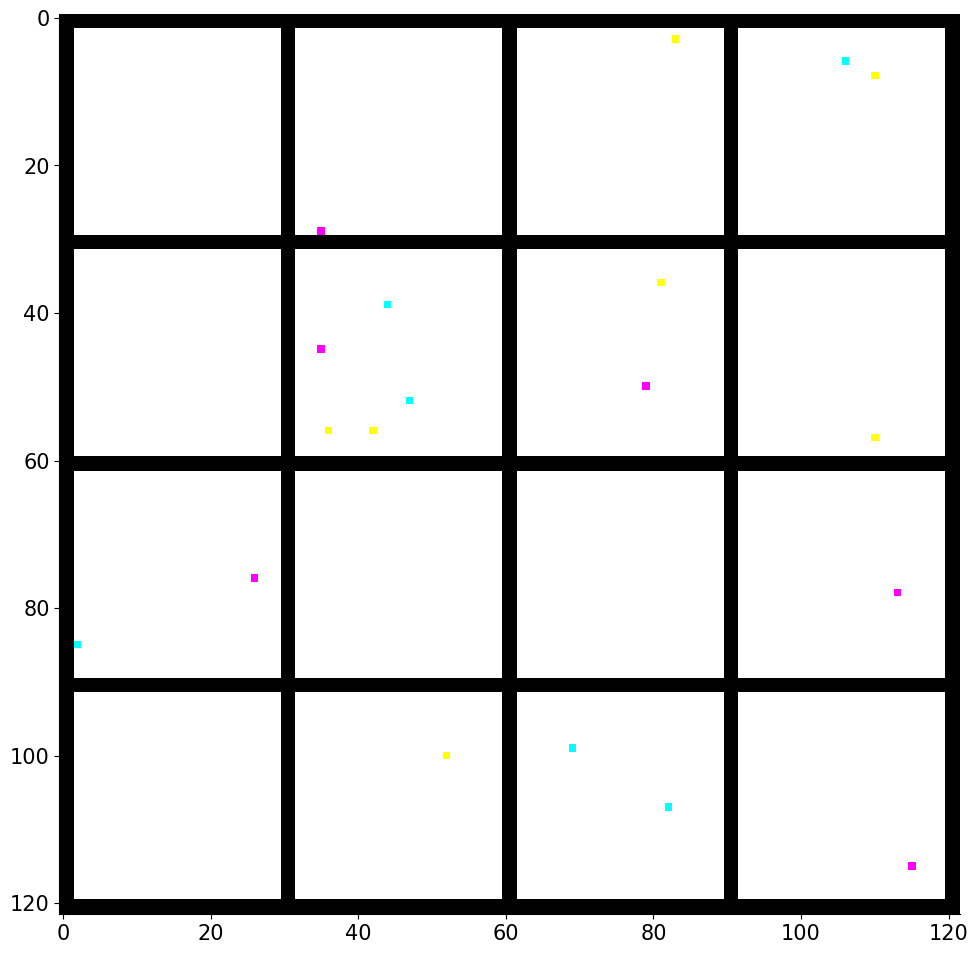

In [14]:
# Model samples
num_sample = 16

with torch.no_grad():
    # y = torch.arange().repeat(num_sample).to(device)
    x, _ = model.sample(num_samples=num_sample)
    x_ = torch.clamp(x, 0, 1)
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(torchvision.utils.make_grid(x_, nrow=4).cpu().numpy(), (1, 2, 0)))
    plt.show()

In [74]:
# split_mode = "channel"
# i = 0
# gblock = nf.flows.GlowBlock(
#     channels=n_chs_now * 2 ** (3 + 1 - i),
#     hidden_channels=hidden_channels,
#     split_mode=split_mode,
#     scale=scale,
# )


# output, ldj = torch.randn(batch_size, 3, 28, 28), 0
# # output
# output = output - output.min()
# output = output / output.max() * 255
# output, ldj = gblock.inverse(output)
# print(ldj.shape)
# print(output.shape)

In [76]:
batch_size = 5

output, ldj = torch.randn(batch_size, 3, 28, 28), 0
# output
output = output - output.min()
output = output / output.max() * 255
# output, ldj = model.forward_and_log_det(output)
output, ldj = model.inverse_and_log_det(output)

print([x.shape for x in output])
print(ldj.shape)
# for idx, flow in enumerate(model.flows):
#     # try:
#     #     print(flow.batch_dims, flow.n_dim, flow.s.shape)
#     # except Exception as e:
#     #     print(idx)
#     output, ldj = flow(output, ldj)
#     print("Running: ", type(flow), output.shape, ldj.shape)

RuntimeError: Given groups=1, weight of size [256, 12, 3, 3], expected input[1, 3, 14, 28] to have 12 channels, but got 3 channels instead